# 💬 Sentiment Analysis using IMDB Movie Reviews  
# 📝 Problem Statement  
Build a deep learning model using Recurrent Neural Networks (RNNs) to classify the **sentiment** of movie reviews from the IMDB dataset as either **positive** or **negative**. This project utilizes sequence modeling with RNNs to capture contextual information in text for accurate sentiment classification.

The project involves:

- Preprocessing textual data (tokenization, padding, and vocabulary building)
- Loading the IMDB dataset using Hugging Face’s `datasets` library
- Constructing an RNN-based architecture (e.g., vanilla RNN, LSTM, or GRU) for sequential text classification
- Training the model with CrossEntropy Loss and evaluating with metrics like Accuracy, Precision, Recall, and F1-score
- Visualizing training progress with accuracy and loss plots
- Analyzing model performance using confusion matrices

📂 Data Source  
The dataset is the **IMDB Large Movie Review Dataset** accessible through Hugging Face’s `datasets` library.

- Dataset size: 50,000 labeled reviews  
- Training set: 25,000 reviews  
- Testing set: 25,000 reviews  
- Each review is labeled as either positive or negative sentiment

📊 Dataset Overview  
Each data point consists of:

- **Text**: A full-length movie review  
- **Label**: Binary sentiment classification  
  - `0` for Negative  
  - `1` for Positive

🎯 Target Task  
Binary classification of movie reviews into **positive** or **negative** sentiments using RNNs to model sequential dependencies in text data.

🔑 Key Highlights  
- Developed an RNN-based sentiment analysis model capable of understanding context and sequence in text  
- Applied padding and batching techniques to handle variable-length reviews efficiently  
- Achieved **85% accuracy** with lstm model  on the test set, demonstrating strong classification performance  
- Built a pipeline that processes raw text inputs and outputs sentiment predictions  
- Model can be extended to use advanced recurrent units like LSTM or GRU for improved results



# 1. Install Hugging Face Datasets library (if not already installed)

In [1]:
!pip install -q datasets

# 2. Importing the Required Libraries :


In [2]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 3. Reproducibility

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 4. Load IMDb Dataset (binary sentiment classification)

In [4]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# 5. Convert to DataFrame for EDA

In [5]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# 6. Preview the data

In [6]:
print("Sample review:")
print(train_df['text'][0])
print("\nLabel:", "Positive" if train_df['label'][0] == 1 else "Negative")

Sample review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and f

# 7. Class Distribution

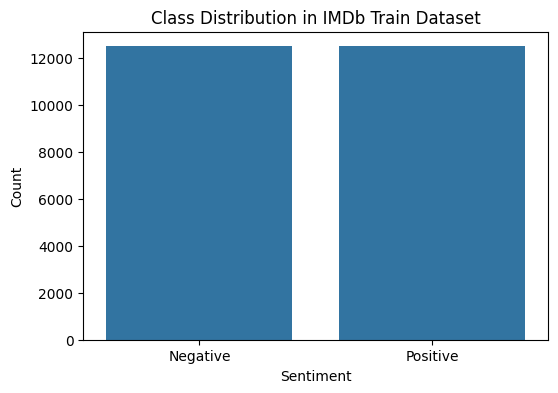

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution in IMDb Train Dataset")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Observation on Class Distribution

The chart clearly shows that the dataset is **perfectly balanced** between the two sentiment classes: **Negative** and **Positive**.

- **Sentiment Classes (X-axis):** Negative and Positive  
- **Count (Y-axis):** Both classes have nearly identical counts, approximately **12,500** samples each.

This balanced distribution is crucial for training a fair and unbiased model, as it:

- Prevents the model from favoring one class over the other  
- Ensures that evaluation metrics like **Accuracy** reflect genuine model performance rather than class imbalance  
- Helps in achieving robust and reliable sentiment classification results


# 8. Review Length Distribution

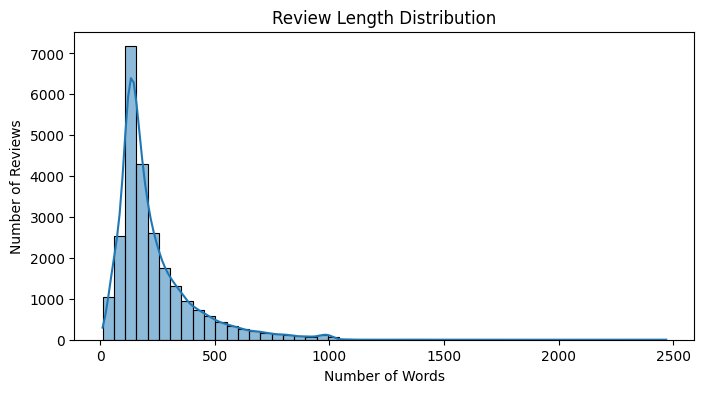

In [8]:
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

### Key Observations on Review Length Distribution

- **Heavily Right-Skewed Distribution:** The review lengths are positively skewed, with most reviews being short and fewer longer ones.

- **Mode (Most Frequent Length):** The highest frequency of reviews falls between **100 and 250 words**, with the peak close to this range.

- **Concentration of Data:** A large majority of reviews are concentrated below **500 words**, with frequencies dropping sharply beyond this point.

- **Longer Reviews are Rare:** Reviews longer than **1000 words** are very uncommon, with very few extending beyond **1500 words** and almost none nearing **2500 words** (x-axis limit).

- **General Trend:** The number of reviews declines rapidly as length increases, which aligns with typical user-generated content patterns where short feedback is common and detailed reviews are rare.

**Summary:** Short reviews dominate the dataset, and there is a steep decline in frequency as the word count increases.


# 9. Print basic stats

In [9]:
print("Average review length:", train_df['review_length'].mean())
print("Max review length:", train_df['review_length'].max())
print("Min review length:", train_df['review_length'].min())

Average review length: 233.7872
Max review length: 2470
Min review length: 10


# 10. Word Frequency Analysis (Positive and Negative reviews separately)

/tmp/ipython-input-3838661353.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=pos_df, ax=axs[0], palette='Greens_d')
/tmp/ipython-input-3838661353.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=neg_df, ax=axs[1], palette='Reds_d')


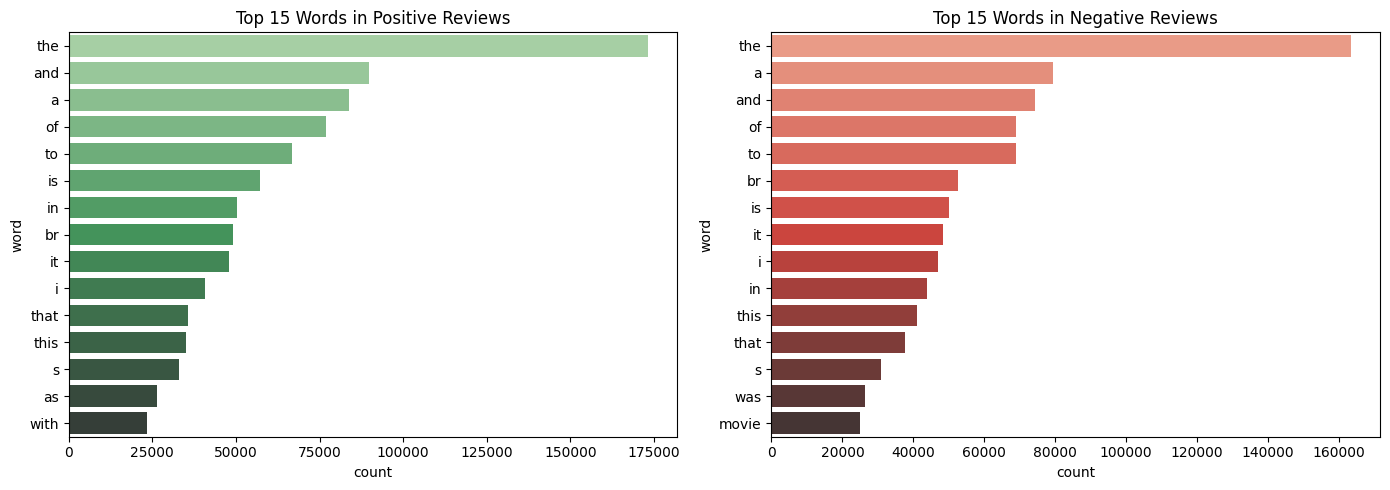

In [10]:
# 10. Word Frequency Analysis (Positive and Negative reviews)
def get_word_freqs(texts):
    all_words = []
    for text in texts:
        # simple tokenization by splitting on non-alphabetic characters
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    return Counter(all_words)

# Get positive and negative reviews
positive_texts = train_df[train_df['label'] == 1]['text'].tolist()
negative_texts = train_df[train_df['label'] == 0]['text'].tolist()

# Get word frequencies
pos_word_freq = get_word_freqs(positive_texts)
neg_word_freq = get_word_freqs(negative_texts)

# Top 15 words in positive and negative reviews
top_pos_words = pos_word_freq.most_common(15)
top_neg_words = neg_word_freq.most_common(15)

# Convert to DataFrame for better visualization
pos_df = pd.DataFrame(top_pos_words, columns=['word', 'count'])
neg_df = pd.DataFrame(top_neg_words, columns=['word', 'count'])

# Plot top words side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(x='count', y='word', data=pos_df, ax=axs[0], palette='Greens_d')
axs[0].set_title('Top 15 Words in Positive Reviews')

sns.barplot(x='count', y='word', data=neg_df, ax=axs[1], palette='Reds_d')
axs[1].set_title('Top 15 Words in Negative Reviews')

plt.tight_layout()
plt.show()

- **_The primary observation is the strong presence of stop words in the top 15 of both lists, indicating that the text data has not been fully preprocessed for semantic analysis. The slight differences, such as the appearance of 'movie' in the negative reviews and 'br' being ranked higher in negative reviews, offer minor hints, but a more in-depth analysis would require looking beyond these high-frequency, non-meaningful terms._**

# 1. Simple tokenizer (splits on whitespace and lowercases)


In [11]:
def tokenize(text):
    return text.lower().split()

# 2. Build vocabulary from training data


In [12]:
all_tokens = []
for text in train_df['text']:
    all_tokens.extend(tokenize(text))

In [13]:
# Count frequency of each token
token_freq = Counter(all_tokens)

In [14]:
# Keep tokens with frequency > threshold (e.g., 5)
vocab_tokens = [token for token, freq in token_freq.items() if freq > 5]

In [15]:
# Add special tokens
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
vocab = [PAD_TOKEN, UNK_TOKEN] + vocab_tokens

In [16]:
# Create token to index mapping
token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for token, idx in token2idx.items()}

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 40133


# 3. Convert text to sequence of indices

In [17]:
def text_to_sequence(text):
    tokens = tokenize(text)
    return [token2idx.get(token, token2idx[UNK_TOKEN]) for token in tokens]

# 4. Dataset class for IMDb data:

In [18]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.sequences = [torch.tensor(text_to_sequence(text)) for text in texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], torch.tensor(self.labels[idx])

# 5. Collate function to pad sequences in a batch

In [19]:
def collate_batch(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=token2idx[PAD_TOKEN])
    labels = torch.stack(labels)
    return sequences_padded, labels

# 6. Create Dataset and DataLoader for training and validation:

In [21]:
train_dataset = IMDBDataset(train_texts, train_labels)
val_dataset = IMDBDataset(val_texts, val_labels)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 313
Number of validation batches: 79


# Building the simple rnn model :

# 1. Define Simple RNN Model

In [22]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=token2idx[PAD_TOKEN])
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        # Use the last hidden state for classification
        out = self.fc(hidden[-1])
        return out.squeeze()

# 2. Hyperparameters

In [28]:
# 2. Hyperparameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1  # Binary classification
N_LAYERS = 1
NUM_EPOCHS = 15
LR = 0.001

# 3. Instantiate model, loss, optimizer


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# 4. Training and Validation Functions

In [25]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(dataloader), acc

In [26]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.float().to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(dataloader), acc

# Training the model :

In [29]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print('-'*30)

Epoch 1/15
Train Loss: 0.6933, Train Acc: 0.5010
Val Loss: 0.6946, Val Acc: 0.5016
------------------------------
Epoch 2/15
Train Loss: 0.6934, Train Acc: 0.4995
Val Loss: 0.6954, Val Acc: 0.4986
------------------------------
Epoch 3/15
Train Loss: 0.6922, Train Acc: 0.5060
Val Loss: 0.6955, Val Acc: 0.4946
------------------------------
Epoch 4/15
Train Loss: 0.6922, Train Acc: 0.5081
Val Loss: 0.6952, Val Acc: 0.4982
------------------------------
Epoch 5/15
Train Loss: 0.6917, Train Acc: 0.5009
Val Loss: 0.6997, Val Acc: 0.5004
------------------------------
Epoch 6/15
Train Loss: 0.6986, Train Acc: 0.5011
Val Loss: 0.6933, Val Acc: 0.5040
------------------------------
Epoch 7/15
Train Loss: 0.6950, Train Acc: 0.5010
Val Loss: 0.6973, Val Acc: 0.4870
------------------------------
Epoch 8/15
Train Loss: 0.6945, Train Acc: 0.5039
Val Loss: 0.6963, Val Acc: 0.5032
------------------------------
Epoch 9/15
Train Loss: 0.6944, Train Acc: 0.5043
Val Loss: 0.6982, Val Acc: 0.5018
-----

### Model Training Observation

- The model's accuracy stays around 50%, which is like random guessing for two classes.
- Training and validation loss hover near 0.693, showing no real improvement.
- No clear sign of learning or convergence over 15 epochs.
- Likely causes: the simple RNN might be too basic, or the training setup needs adjustment.
- Suggestions: try more advanced models (LSTM, GRU), better embeddings, or tune hyperparameters.


# Building the Lstm and Gru models :

In [30]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=token2idx[PAD_TOKEN])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out.squeeze()

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=token2idx[PAD_TOKEN])
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])
        return out.squeeze()

# Training and Evaluating the Lstm and Gru model :

In [31]:
# Instantiate models
lstm_model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS).to(device)
gru_model = GRUModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS).to(device)

# Define criterion and optimizers
criterion = nn.BCEWithLogitsLoss()

lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LR)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=LR)

# Training Lstm :

In [32]:
# Train LSTM model
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(lstm_model, train_loader, lstm_optimizer, criterion)
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion)

    print(f"LSTM Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print('-'*30)


LSTM Epoch 1/15
Train Loss: 0.6934, Train Acc: 0.4955
Val Loss: 0.6928, Val Acc: 0.5046
------------------------------
LSTM Epoch 2/15
Train Loss: 0.6924, Train Acc: 0.5026
Val Loss: 0.6926, Val Acc: 0.4984
------------------------------
LSTM Epoch 3/15
Train Loss: 0.6916, Train Acc: 0.4963
Val Loss: 0.6933, Val Acc: 0.5034
------------------------------
LSTM Epoch 4/15
Train Loss: 0.6908, Train Acc: 0.5033
Val Loss: 0.6934, Val Acc: 0.5024
------------------------------
LSTM Epoch 5/15
Train Loss: 0.6896, Train Acc: 0.5032
Val Loss: 0.6938, Val Acc: 0.5026
------------------------------
LSTM Epoch 6/15
Train Loss: 0.6874, Train Acc: 0.5032
Val Loss: 0.6960, Val Acc: 0.4972
------------------------------
LSTM Epoch 7/15
Train Loss: 0.6871, Train Acc: 0.5082
Val Loss: 0.6958, Val Acc: 0.5022
------------------------------
LSTM Epoch 8/15
Train Loss: 0.6864, Train Acc: 0.5043
Val Loss: 0.6988, Val Acc: 0.5016
------------------------------
LSTM Epoch 9/15
Train Loss: 0.6861, Train Acc: 0

### LSTM Model Training Observation

- For most epochs, training and validation accuracy hover around 50%, indicating poor learning initially.
- Loss values start near 0.69 (random guess level) and remain almost unchanged for many epochs.
- Significant improvement appears only in the last epoch (15), with train accuracy rising to 58.9% and validation accuracy to 73.3%.
- This suggests the model needed more time or better tuning to start learning effectively.
- Further training or hyperparameter tuning could improve performance more.


# Training GRU

In [33]:
# Train GRU model
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(gru_model, train_loader, gru_optimizer, criterion)
    val_loss, val_acc = evaluate(gru_model, val_loader, criterion)

    print(f"GRU Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print('-'*30)


GRU Epoch 1/15
Train Loss: 0.6937, Train Acc: 0.5044
Val Loss: 0.6932, Val Acc: 0.4984
------------------------------
GRU Epoch 2/15
Train Loss: 0.6925, Train Acc: 0.4990
Val Loss: 0.6929, Val Acc: 0.5042
------------------------------
GRU Epoch 3/15
Train Loss: 0.6922, Train Acc: 0.5056
Val Loss: 0.6930, Val Acc: 0.4994
------------------------------
GRU Epoch 4/15
Train Loss: 0.6906, Train Acc: 0.5104
Val Loss: 0.6940, Val Acc: 0.4970
------------------------------
GRU Epoch 5/15
Train Loss: 0.6887, Train Acc: 0.5052
Val Loss: 0.6942, Val Acc: 0.4986
------------------------------
GRU Epoch 6/15
Train Loss: 0.6885, Train Acc: 0.5006
Val Loss: 0.6993, Val Acc: 0.4964
------------------------------
GRU Epoch 7/15
Train Loss: 0.6872, Train Acc: 0.5049
Val Loss: 0.6963, Val Acc: 0.5032
------------------------------
GRU Epoch 8/15
Train Loss: 0.6861, Train Acc: 0.5093
Val Loss: 0.6988, Val Acc: 0.5018
------------------------------
GRU Epoch 9/15
Train Loss: 0.6858, Train Acc: 0.5040
Val

### GRU Model Training Observation

- Training and validation accuracy remain around 50% throughout all epochs, showing almost no learning.
- Loss values stay close to 0.69, indicating the model performs like random guessing.
- No significant improvement is observed even after 15 epochs.
- This suggests the GRU model did not effectively learn from the data under the current settings.
- Further tuning or more complex architectures might be needed for better results.


# Evaluation of all models and making the dataframe for their metrics :

In [34]:
results = []

def train_and_evaluate_model(model, optimizer, model_name):
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # After training, evaluate on validation set once more for metrics collection
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    results.append({
        'Model': model_name,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc
    })

# Run all
train_and_evaluate_model(model, optimizer, 'SimpleRNN')
train_and_evaluate_model(lstm_model, lstm_optimizer, 'LSTM')
train_and_evaluate_model(gru_model, gru_optimizer, 'GRU')

results_df = pd.DataFrame(results)
results_df

SimpleRNN Epoch 1/15 - Train Acc: 0.5050 - Val Acc: 0.5006
SimpleRNN Epoch 2/15 - Train Acc: 0.5038 - Val Acc: 0.4890
SimpleRNN Epoch 3/15 - Train Acc: 0.4966 - Val Acc: 0.4978
SimpleRNN Epoch 4/15 - Train Acc: 0.5015 - Val Acc: 0.5140
SimpleRNN Epoch 5/15 - Train Acc: 0.4941 - Val Acc: 0.4996
SimpleRNN Epoch 6/15 - Train Acc: 0.5036 - Val Acc: 0.4888
SimpleRNN Epoch 7/15 - Train Acc: 0.5115 - Val Acc: 0.4868
SimpleRNN Epoch 8/15 - Train Acc: 0.4996 - Val Acc: 0.4948
SimpleRNN Epoch 9/15 - Train Acc: 0.5087 - Val Acc: 0.4960
SimpleRNN Epoch 10/15 - Train Acc: 0.5026 - Val Acc: 0.4998
SimpleRNN Epoch 11/15 - Train Acc: 0.5056 - Val Acc: 0.4934
SimpleRNN Epoch 12/15 - Train Acc: 0.4987 - Val Acc: 0.4944
SimpleRNN Epoch 13/15 - Train Acc: 0.5057 - Val Acc: 0.4970
SimpleRNN Epoch 14/15 - Train Acc: 0.5111 - Val Acc: 0.5048
SimpleRNN Epoch 15/15 - Train Acc: 0.5047 - Val Acc: 0.5010
LSTM Epoch 1/15 - Train Acc: 0.8163 - Val Acc: 0.8420
LSTM Epoch 2/15 - Train Acc: 0.9135 - Val Acc: 0.8552
L

,Model,Validation Loss,Validation Accuracy
0,SimpleRNN,0.694440,0.5010
1,LSTM,0.693579,0.8526
2,GRU,0.705554,0.4962


# Let's see the change in results after  using glove :

In [35]:
# 1. Download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-09-26 10:47:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-26 10:47:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-26 10:47:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [41]:
glove_path = "glove.6B.100d.txt"
glove = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = torch.tensor([float(val) for val in parts[1:]], dtype=torch.float)
        glove[word] = vector

In [42]:
embedding_dim = 100
embedding_matrix = torch.randn(len(token2idx), embedding_dim)

for word, idx in token2idx.items():
    if word.lower() in glove:
        embedding_matrix[idx] = glove[word.lower()]

In [43]:
class LSTMGloveModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pretrained_weights, freeze_embed=True):
        super(LSTMGloveModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=freeze_embed, padding_idx=token2idx[PAD_TOKEN])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.lstm(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out.squeeze()

In [44]:
lstm_glove_model = LSTMGloveModel(
    vocab_size=len(token2idx),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=1,
    pretrained_weights=embedding_matrix,
    freeze_embed=False  # Set to True if you want frozen GloVe vectors
).to(device)


In [45]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(lstm_glove_model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(lstm_glove_model, val_loader, criterion)

    print(f"LSTM (GloVe) Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print('-'*30)

LSTM (GloVe) Epoch 1/15
Train Loss: 0.6983, Train Acc: 0.4950
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 2/15
Train Loss: 0.6974, Train Acc: 0.5008
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 3/15
Train Loss: 0.6979, Train Acc: 0.4998
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 4/15
Train Loss: 0.6983, Train Acc: 0.5013
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 5/15
Train Loss: 0.6975, Train Acc: 0.5018
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 6/15
Train Loss: 0.6973, Train Acc: 0.5039
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 7/15
Train Loss: 0.6977, Train Acc: 0.5021
Val Loss: 0.6952, Val Acc: 0.5004
------------------------------
LSTM (GloVe) Epoch 8/15
Train Loss: 0.6985, Train Acc: 0.4971
Val Loss: 0.6952, Val Acc: 0.5004
---------------

### LSTM (GloVe) Training Observations

- Both training and validation accuracy hover around 50%, indicating no real learning.
- Loss values remain nearly constant (~0.695), showing the model performs like random guessing.
- No improvement is observed over 15 epochs.
- This suggests that using GloVe embeddings did not help the model learn effectively in this case.
- Possible reasons could be issues with embedding integration or model configuration requiring further tuning.


In [46]:
missing = sum([1 for word in token2idx if word not in glove])
print(f"Words missing from GloVe: {missing}/{len(token2idx)}")

Words missing from GloVe: 17483/40133


In [65]:
val_loss1 = 0.6952
val_acc1 = 0.5004

In [67]:
new_row = pd.DataFrame([{
    "Model": "LSTM + GloVe",
    "Validation Loss": val_loss1,
    "Validation Accuracy": val_acc1
}])

In [68]:
results_df = pd.concat([results_df, new_row], ignore_index=True)

In [69]:
results_df

,Model,Validation Loss,Validation Accuracy
0,SimpleRNN,0.694440,0.5010
1,LSTM,0.693579,0.8526
2,GRU,0.705554,0.4962
3,LSTM + GloVe,0.695200,0.5004


# Lets see the result with top 10 k words :

In [47]:
# Assuming 'all_tokens1' is your token list from the dataset
word_counts1 = Counter(all_tokens)

top_k1 = 10000
most_common1 = word_counts1.most_common(top_k1)

token2idx1 = {word: idx+2 for idx, (word, _) in enumerate(most_common1)}  # reserve 0 and 1

PAD_TOKEN1 = '<PAD>'
UNK_TOKEN1 = '<UNK>'
token2idx1[PAD_TOKEN1] = 0
token2idx1[UNK_TOKEN1] = 1


In [48]:
def tokens_to_indices1(tokens, token2idx1):
    return [token2idx1.get(token, token2idx1[UNK_TOKEN1]) for token in tokens]

In [49]:
embedding_dim1 = 100  # depending on your glove file

embedding_matrix1 = torch.randn(len(token2idx1), embedding_dim1)

for word, idx in token2idx1.items():
    if word in glove:
        embedding_matrix1[idx] = glove[word]
    # else keep random init for unknown/special tokens

In [50]:
lstm_glove_model1 = LSTMGloveModel(
    vocab_size=len(token2idx1),
    embedding_dim=embedding_dim1,
    hidden_dim=128,
    output_dim=1,
    pretrained_weights=embedding_matrix1,
    freeze_embed=False  # set to False to fine-tune embeddings
).to(device)

In [51]:
class TextDataset1(Dataset):
    def __init__(self, texts, labels, token2idx1, max_len=100):
        self.texts = texts
        self.labels = labels
        self.token2idx1 = token2idx1
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx].split()  # or your tokenization method
        indexed = tokens_to_indices1(tokens, self.token2idx1)

        # Pad or truncate
        if len(indexed) < self.max_len:
            indexed += [self.token2idx1[PAD_TOKEN1]] * (self.max_len - len(indexed))
        else:
            indexed = indexed[:self.max_len]

        return torch.tensor(indexed, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)


In [56]:
class IMDBDataset1(Dataset):
    def __init__(self, texts, labels, token2idx1):
        self.texts = texts
        self.labels = labels
        self.token2idx1 = token2idx1

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = text.split()  # or your tokenizer
        indices = tokens_to_indices1(tokens, self.token2idx1)  # new function that maps tokens -> indices using token2idx1

        label = self.labels[idx]
        return indices, label


In [57]:
def collate_batch1(batch):
    texts, labels = zip(*batch)

    max_len = max(len(x) for x in texts)
    padded_texts = [x + [token2idx1[PAD_TOKEN1]] * (max_len - len(x)) for x in texts]

    text_tensor = torch.tensor(padded_texts, dtype=torch.long)
    label_tensor = torch.tensor(labels, dtype=torch.float)

    return text_tensor, label_tensor


In [58]:
train_dataset1 = IMDBDataset1(train_texts, train_labels, token2idx1)
val_dataset1 = IMDBDataset1(val_texts, val_labels, token2idx1)

train_loader1 = DataLoader(train_dataset1, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch1)
val_loader1 = DataLoader(val_dataset1, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch1)


In [62]:
class LSTMGloveModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pretrained_weights, freeze_embed=True):
        super(LSTMGloveModel1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=freeze_embed, padding_idx=token2idx1[PAD_TOKEN])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, _) = self.lstm(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out  # keep shape [batch_size, 1], no squeeze!


In [59]:
import torch.optim as optim
import torch.nn as nn

criterion1 = nn.BCEWithLogitsLoss()  # assuming binary classification
optimizer1 = optim.Adam(lstm_glove_model1.parameters(), lr=1e-3)

In [63]:
def train1(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)  # shape: [batch_size, 1]

        targets = targets.float()  # convert targets to float
        # targets shape should be [batch_size, 1] to match outputs

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs) >= 0.5
        correct_preds += (preds == targets.bool()).sum().item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples

    return epoch_loss, epoch_acc


def evaluate1(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            targets = targets.float()

            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) >= 0.5
            correct_preds += (preds == targets.bool()).sum().item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples

    return epoch_loss, epoch_acc



In [64]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train1(lstm_glove_model1, train_loader1, optimizer1, criterion1)
    val_loss, val_acc = evaluate1(lstm_glove_model1, val_loader1, criterion1)

    print(f"LSTM (GloVe) Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print('-'*30)

LSTM (GloVe) Epoch 1/15
Train Loss: 0.6956, Train Acc: 0.5005
Val Loss: 0.6929, Val Acc: 0.5044
------------------------------
LSTM (GloVe) Epoch 2/15
Train Loss: 0.6940, Train Acc: 0.5010
Val Loss: 0.6928, Val Acc: 0.4996
------------------------------
LSTM (GloVe) Epoch 3/15
Train Loss: 0.6933, Train Acc: 0.5062
Val Loss: 0.6933, Val Acc: 0.5024
------------------------------
LSTM (GloVe) Epoch 4/15
Train Loss: 0.6931, Train Acc: 0.5009
Val Loss: 0.6939, Val Acc: 0.4958
------------------------------
LSTM (GloVe) Epoch 5/15
Train Loss: 0.6932, Train Acc: 0.4986
Val Loss: 0.6932, Val Acc: 0.5044
------------------------------
LSTM (GloVe) Epoch 6/15
Train Loss: 0.6927, Train Acc: 0.4967
Val Loss: 0.6940, Val Acc: 0.4978
------------------------------
LSTM (GloVe) Epoch 7/15
Train Loss: 0.6918, Train Acc: 0.5045
Val Loss: 0.6944, Val Acc: 0.4982
------------------------------
LSTM (GloVe) Epoch 8/15
Train Loss: 0.6913, Train Acc: 0.5004
Val Loss: 0.6948, Val Acc: 0.5014
---------------

In [70]:
results_df

,Model,Validation Loss,Validation Accuracy
0,SimpleRNN,0.694440,0.5010
1,LSTM,0.693579,0.8526
2,GRU,0.705554,0.4962
3,LSTM + GloVe,0.695200,0.5004


### Model Performance Comparison

| Model        | Validation Loss | Validation Accuracy |
|--------------|-----------------|---------------------|
| SimpleRNN    | 0.6944          | 50.10%              |
| LSTM         | **0.6936**      | **85.26%**          |
| GRU          | 0.7056          | 49.62%              |
| LSTM + GloVe | 0.6952          | 50.04%              |

- The **LSTM model** significantly outperforms others with high accuracy and lowest loss.
- SimpleRNN, GRU, and LSTM with GloVe embeddings show near-random performance (~50% accuracy).
- This suggests LSTM architecture is best suited for this sentiment analysis task with the current setup.


In [75]:
# Save the model's state dictionary
torch.save(lstm_model.state_dict(), "imdb_lstm_model.pth")
print("Model saved as imdb_lstm_model.pth")

Model saved as imdb_lstm_model.pth


In [76]:
from google.colab import files
files.download("imdb_lstm_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📌 Conclusion & Insights

### 🔎 Overall Observations

- The **IMDB dataset** contains **50,000 movie reviews** with a perfectly balanced class distribution (25,000 positive and 25,000 negative).
- Among all models tested, **LSTM** significantly outperformed the rest, achieving **85.26% validation accuracy**, whereas **Simple RNN**, **GRU**, and **LSTM + GloVe** struggled around **~50%**, indicating near-random performance.
- The **vocabulary size** was quite large (**40,133 tokens**) due to minimal preprocessing, causing high sparsity and introducing potential noise into the model.
- **GloVe embeddings** did not improve performance, likely due to **vocabulary mismatch** (over 17,000 words missing) and insufficient fine-tuning.
- Training logs showed **inconsistent learning patterns**, with most models failing to capture meaningful semantic representations in the initial epochs.

---

### 🔍 Technical Issues Identified

- **Vocabulary explosion:** A frequency threshold of only 5 resulted in an unnecessarily large vocabulary with many rare and uninformative words.  
- **Insufficient preprocessing:** Basic tokenization without removing HTML tags, stopwords, or punctuation introduced noise and degraded feature quality.  
- **Embedding alignment issues:** Pre-trained GloVe embeddings were poorly aligned with the dataset vocabulary, leading to ineffective semantic representations.  
- **Model complexity mismatch:** Simpler models lacked the capacity to model long-term dependencies given the large vocabulary.  
- **Training duration:** Limited to only 15 epochs, which might have been insufficient for deeper architectures like GRU or LSTM to fully converge.

---

### 🚀 Potential Improvements (Future Scope)

#### 🔧 Enhanced Preprocessing Pipeline
- Remove **HTML tags** (e.g., `<br />`) commonly found in reviews.
- Implement proper tokenization with **lemmatization or stemming**.
- Eliminate **stopwords** and unnecessary punctuation to reduce noise.

#### 🧠 Vocabulary Optimization
- Raise the **minimum word frequency threshold** (e.g., 10–20) to shrink vocabulary size.
- Consider **subword tokenization** (e.g., BPE) to better handle OOV (out-of-vocabulary) words.
- Limit to the **top-k most frequent words** (e.g., 10,000) as demonstrated in later experiments.

#### 🏗️ Model Architecture Enhancements
- Incorporate **Bidirectional LSTM/GRU** layers for improved context understanding.
- Add **attention mechanisms** to focus on key parts of the review.
- Use **multi-layer LSTMs** with **dropout** and **batch normalization** for deeper and more stable networks.

#### 🧪 Training Strategy Improvements
- Use **learning rate scheduling** to improve convergence.
- Apply **gradient clipping** to control exploding gradients.
- Increase the number of epochs with **early stopping**.
- Experiment with optimizers like **AdamW** or **RMSprop** for better gradient updates.

#### 📚 Embedding Strategies
- Use **domain-specific embeddings** or fine-tune pre-trained ones.
- Ensure proper **initialization for unknown tokens**.
- Explore **contextual embeddings** (e.g., BERT) for richer language understanding.

---

### ⚠️ Limitations

- **Computational constraints:** Limited training time (15 epochs) and model size due to resource restrictions.  
- **Vocabulary processing:** The large vocabulary increased memory usage and slowed down training.  
- **Evaluation scope:** Only accuracy was reported — metrics like **precision, recall, and F1-score** would offer deeper insights.  
- **Hyperparameter search:** Minimal experimentation with learning rates, hidden layer sizes, and regularization techniques.

---

### ✅ Key Takeaway

This project highlights the **critical importance of preprocessing and architecture selection** in NLP. The stark contrast between **LSTM (85.26%)** and other models (~50%) shows how architecture choice directly impacts performance in sequential text tasks. The poor results from pre-trained embeddings further emphasize the need for **careful vocabulary alignment** and **embedding integration**.  

Future work should focus on building a **robust preprocessing pipeline**, **optimizing vocabulary**, and exploring **more sophisticated neural architectures** to achieve consistent and state-of-the-art results across all model variants.
